# TE on the data where resolution changes over time

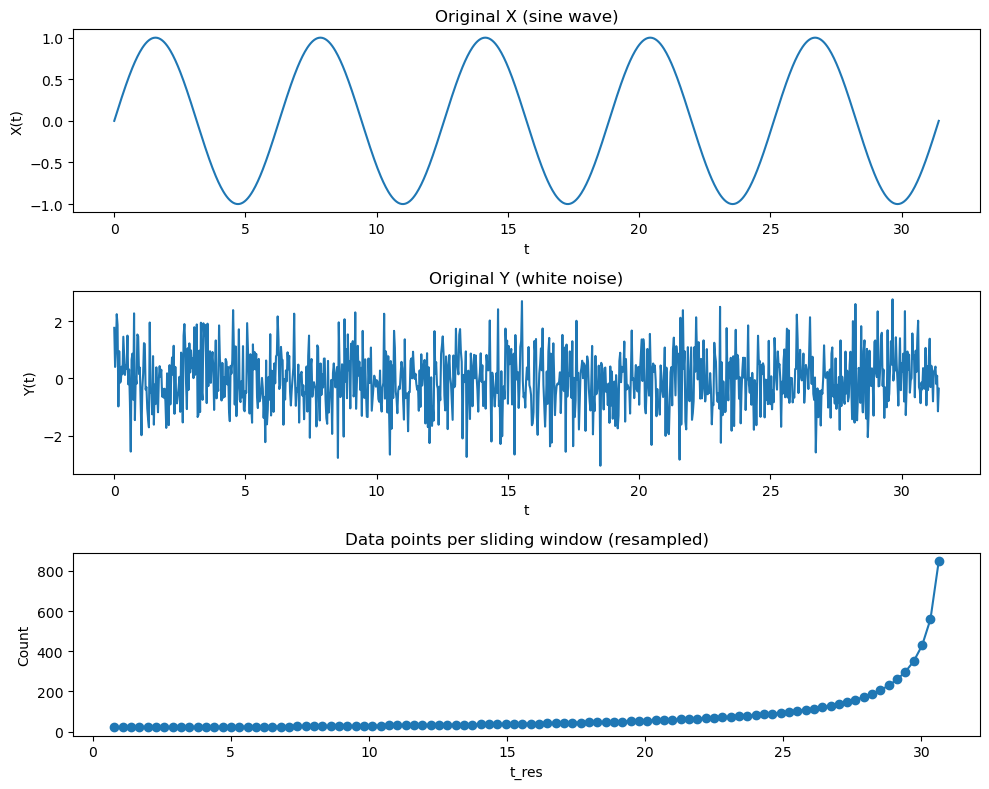

Original signals (xbins=6, ybins=2): TE = 0.0091, p-value = 0.230
Resampled signals (xbins=6, ybins=2): TE = 0.0286, p-value = 0.000


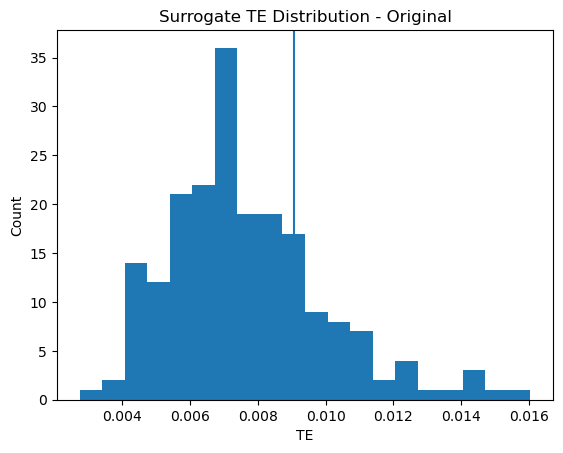

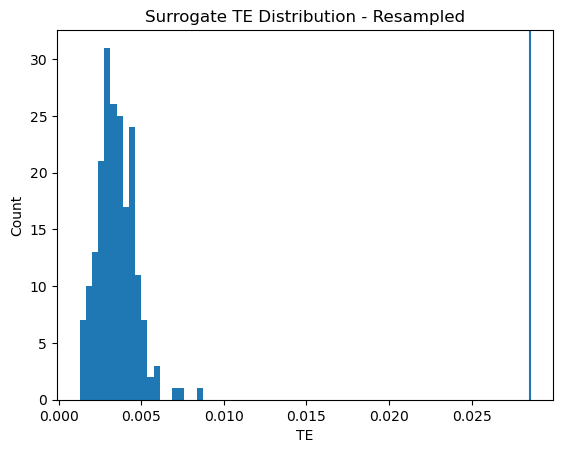

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
N = 1000
cycles = 5
np.random.seed(0)

# Generate original signals
t = np.linspace(0, cycles * 2 * np.pi, N)
X = np.sin(t)
Y = np.random.normal(0, 1, size=N)

# Resampling parameters
M = 2000
beta = 5.0
t_res = t[-1] * (1 - np.exp(-beta * np.arange(M) / (M - 1))) / (1 - np.exp(-beta))
X_res = np.interp(t_res, t, X)
Y_res = np.interp(t_res, t, Y)

# 1. Plot X and Y and sliding-window counts for resampled
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
axs[0].plot(t, X)
axs[0].set_title('Original X (sine wave)')
axs[0].set_xlabel('t')
axs[0].set_ylabel('X(t)')

axs[1].plot(t, Y)
axs[1].set_title('Original Y (white noise)')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Y(t)')

# Sliding window count over resampled time
window_width = (t[-1] - t[0]) / 20
centers = np.linspace(t_res[0] + window_width/2,
                      t_res[-1] - window_width/2, 100)
counts = [np.sum((t_res >= c - window_width/2) &
                 (t_res < c + window_width/2)) for c in centers]

axs[2].plot(centers, counts, marker='o')
axs[2].set_title('Data points per sliding window (resampled)')
axs[2].set_xlabel('t_res')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 2. TE with separate bins: xbins=6, ybins=2
def compute_TE(source, target, bins_source, bins_target):
    edges_src = np.histogram(source, bins=bins_source)[1]
    edges_tgt = np.histogram(target, bins=bins_target)[1]
    src_b = np.digitize(source, edges_src) - 1
    tgt_b = np.digitize(target, edges_tgt) - 1
    counts_xyz = {}
    counts_zy = {}
    counts_xz = {}
    counts_z = {}
    M = len(source) - 1
    for k in range(M):
        x = tgt_b[k+1]  # future target
        z = tgt_b[k]    # past target
        y = src_b[k]    # past source
        counts_xyz[(x, z, y)] = counts_xyz.get((x, z, y), 0) + 1
        counts_zy[(z, y)]       = counts_zy.get((z, y), 0) + 1
        counts_xz[(x, z)]       = counts_xz.get((x, z), 0) + 1
        counts_z[z]             = counts_z.get(z, 0) + 1
    TE = 0.0
    for (x, z, y), c_xyz in counts_xyz.items():
        p_xyz = c_xyz / M
        p_zy  = counts_zy[(z, y)] / M
        p_xz  = counts_xz[(x, z)] / M
        p_z   = counts_z[z] / M
        TE   += p_xyz * np.log((p_xyz / p_zy) / (p_xz / p_z))
    return TE

def surrogate_TE(source, target, bins_source, bins_target, n_surr=200):
    TE_obs = compute_TE(source, target, bins_source, bins_target)
    TE_surr = []
    for _ in range(n_surr):
        src_shuf = np.random.permutation(source)
        TE_surr.append(compute_TE(src_shuf, target, bins_source, bins_target))
    TE_surr = np.array(TE_surr)
    p_value = np.mean(TE_surr >= TE_obs)
    return TE_obs, p_value, TE_surr

xbins, ybins = 6, 2
TE_orig, p_orig, TE_surr_orig = surrogate_TE(X, Y, xbins, ybins)
TE_res, p_res, TE_surr_res   = surrogate_TE(X_res, Y_res, xbins, ybins)

print(f"Original signals (xbins={xbins}, ybins={ybins}): TE = {TE_orig:.4f}, p-value = {p_orig:.3f}")
print(f"Resampled signals (xbins={xbins}, ybins={ybins}): TE = {TE_res:.4f}, p-value = {p_res:.3f}")


# Plot surrogate distributions
plt.figure()
plt.hist(TE_surr_orig, bins=20)
plt.axvline(TE_orig)
plt.title("Surrogate TE Distribution - Original")
plt.xlabel("TE")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(TE_surr_res, bins=20)
plt.axvline(TE_res)
plt.title("Surrogate TE Distribution - Resampled")
plt.xlabel("TE")
plt.ylabel("Count")
plt.show()

Original (continuous X → spikes Y): TE = 0.0001, p-value = 0.145
Resampled (continuous X_res → spikes Y_res): TE = 0.0001, p-value = 0.515


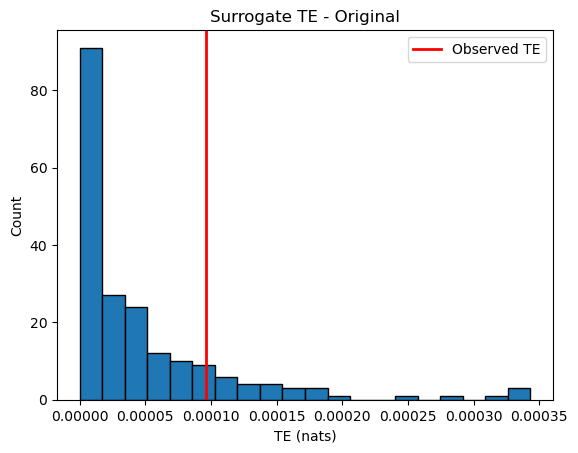

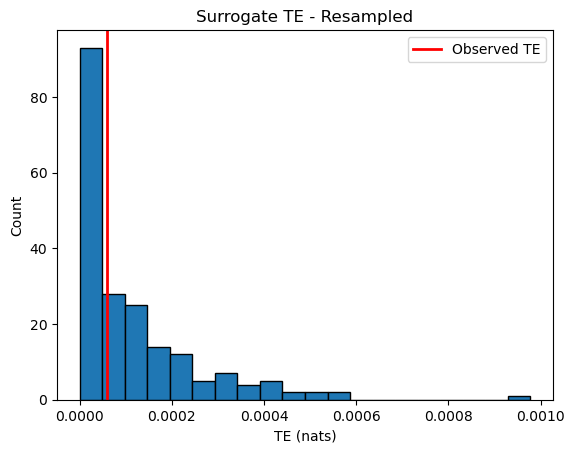

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings

# Suppress future warnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# Settings
N = 10000
cycles = 5
np.random.seed(0)

# Generate original signals
t = np.linspace(0, cycles * 2 * np.pi, N)
X = np.sin(t)
Y = np.random.normal(0, 1, size=N)

# Resampling parameters
M = 5000
beta = 5.0
t_res = t[-1] * (1 - np.exp(-beta * np.arange(M) / (M - 1))) / (1 - np.exp(-beta))
X_res = np.interp(t_res, t, X)
Y_res = np.interp(t_res, t, Y)

# Convert Y to spikes (point process) via thresholding at 90th percentile
th_Y = np.percentile(Y, 50)
th_Yr = np.percentile(Y_res, 50)
spike_Y = (Y > th_Y).astype(int)
spike_Yr = (Y_res > th_Yr).astype(int)

# Continuous-to-point TE via logistic regression
def compute_TE_cont2point(X, Y, lag=1):
    # Prepare data
    X_prev = X[:-lag].reshape(-1, 1)
    Y_prev = Y[:-lag].reshape(-1, 1)
    Y_next = Y[lag:]
    
    # Model without X: use large C to approximate no regularization
    # model0 = LogisticRegression(C=1e12, solver='lbfgs', max_iter=1000)
    model0 = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
    model0.fit(Y_prev, Y_next)
    p0 = model0.predict_proba(Y_prev)
    
    # Model with X: likewise
    features = np.hstack((Y_prev, X_prev))
    model1 = LogisticRegression(C=1e12, solver='lbfgs', max_iter=1000)
    model1.fit(features, Y_next)
    p1 = model1.predict_proba(features)
    
    # Compute TE as average log-likelihood difference
    idx = np.arange(len(Y_next))
    logp0 = np.log(p0[idx, Y_next])
    logp1 = np.log(p1[idx, Y_next])
    return np.mean(logp1 - logp0)

# Surrogate test
def surrogate_TE_cont2point(X, Y, n_surr=200):
    TE_obs = compute_TE_cont2point(X, Y)
    TE_surr = []
    for _ in range(n_surr):
        X_shuf = np.random.permutation(X)
        TE_surr.append(compute_TE_cont2point(X_shuf, Y))
    TE_surr = np.array(TE_surr)
    p_value = np.mean(TE_surr >= TE_obs)
    return TE_obs, p_value, TE_surr

# Compute on original and resampled
TE_orig, p_orig, surr_orig = surrogate_TE_cont2point(X, spike_Y)
TE_res, p_res, surr_res = surrogate_TE_cont2point(X_res, spike_Yr)

print(f"Original (continuous X → spikes Y): TE = {TE_orig:.4f}, p-value = {p_orig:.3f}")
print(f"Resampled (continuous X_res → spikes Y_res): TE = {TE_res:.4f}, p-value = {p_res:.3f}")

# Plot surrogate distributions
plt.figure()
plt.hist(surr_orig, bins=20, edgecolor='k')
plt.axvline(TE_orig, color='r', linewidth=2, label='Observed TE')
plt.title("Surrogate TE - Original")
plt.xlabel("TE (nats)")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure()
plt.hist(surr_res, bins=20, edgecolor='k')
plt.axvline(TE_res, color='r', linewidth=2, label='Observed TE')
plt.title("Surrogate TE - Resampled")
plt.xlabel("TE (nats)")
plt.ylabel("Count")
plt.legend()
plt.show()


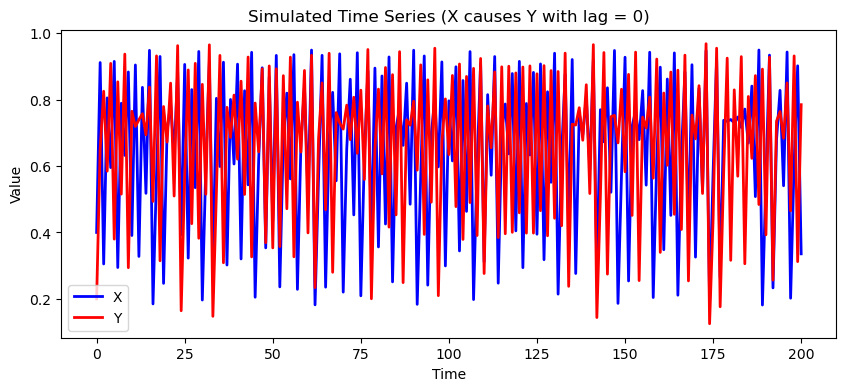

Original (continuous X → spikes Y): TE = 0.0188, p-value = 0.005
Resampled (continuous X_res → spikes Y_res): TE = 0.0188, p-value = 0.010


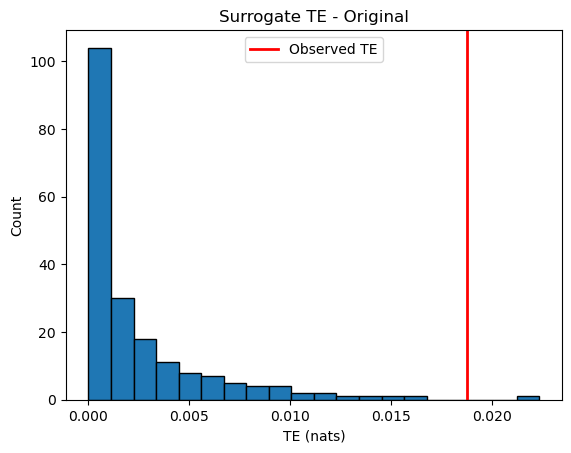

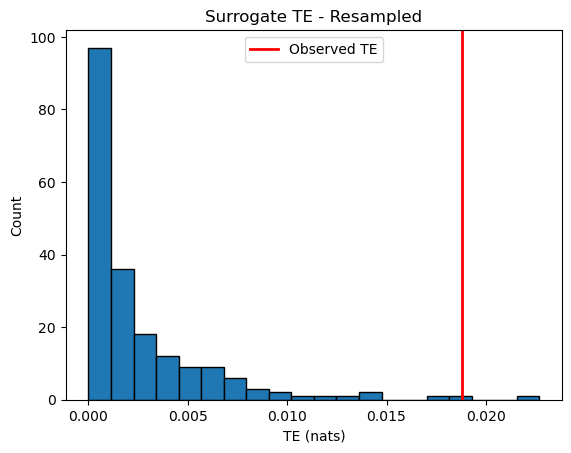

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings

# Suppress future warnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}



r_x = 3.8        
r_y = 3.5       
B_yx = 0.1      
LAG = 0          
t_total = 200    

X = np.zeros(t_total + 1)
Y = np.zeros(t_total + 1)
X[0] = 0.4
Y[0] = 0.2

for t in range(t_total):
    X[t+1] = r_x * X[t] * (1 - X[t])
    if (t + 1) < LAG:
        Y[t+1] = r_y * Y[t] * (1 - Y[t])
    else:
        Y[t+1] = r_y * Y[t] * (1 - Y[t]) + B_yx * X[t - LAG + 1]

time = np.arange(t_total + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, X, 'b-', linewidth=2, label='X')
plt.plot(time, Y, 'r-', linewidth=2, label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Simulated Time Series (X causes Y with lag = {LAG})')
plt.legend()
plt.show()


# save X and Y to csv and add a time column
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})


X_res = df['X'].values
Y_res = df['Y'].values

# Convert Y to spikes (point process) via thresholding at 90th percentile
th_Y = np.percentile(Y, 50)
th_Yr = np.percentile(Y_res, 50)
spike_Y = (Y > th_Y).astype(int)
spike_Yr = (Y_res > th_Yr).astype(int)

# Continuous-to-point TE via logistic regression
def compute_TE_cont2point(X, Y, lag=1):
    # Prepare data
    X_prev = X[:-lag].reshape(-1, 1)
    Y_prev = Y[:-lag].reshape(-1, 1)
    Y_next = Y[lag:]
    
    # Model without X: use large C to approximate no regularization
    # model0 = LogisticRegression(C=1e12, solver='lbfgs', max_iter=1000)
    model0 = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
    model0.fit(Y_prev, Y_next)
    p0 = model0.predict_proba(Y_prev)
    
    # Model with X: likewise
    features = np.hstack((Y_prev, X_prev))
    model1 = LogisticRegression(C=1e12, solver='lbfgs', max_iter=1000)
    model1.fit(features, Y_next)
    p1 = model1.predict_proba(features)
    
    # Compute TE as average log-likelihood difference
    idx = np.arange(len(Y_next))
    logp0 = np.log(p0[idx, Y_next])
    logp1 = np.log(p1[idx, Y_next])
    return np.mean(logp1 - logp0)

# Surrogate test
def surrogate_TE_cont2point(X, Y, n_surr=200):
    TE_obs = compute_TE_cont2point(X, Y)
    TE_surr = []
    for _ in range(n_surr):
        X_shuf = np.random.permutation(X)
        TE_surr.append(compute_TE_cont2point(X_shuf, Y))
    TE_surr = np.array(TE_surr)
    p_value = np.mean(TE_surr >= TE_obs)
    return TE_obs, p_value, TE_surr

# Compute on original and resampled
TE_orig, p_orig, surr_orig = surrogate_TE_cont2point(X, spike_Y)
TE_res, p_res, surr_res = surrogate_TE_cont2point(X_res, spike_Yr)

print(f"Original (continuous X → spikes Y): TE = {TE_orig:.4f}, p-value = {p_orig:.3f}")
print(f"Resampled (continuous X_res → spikes Y_res): TE = {TE_res:.4f}, p-value = {p_res:.3f}")

# Plot surrogate distributions
plt.figure()
plt.hist(surr_orig, bins=20, edgecolor='k')
plt.axvline(TE_orig, color='r', linewidth=2, label='Observed TE')
plt.title("Surrogate TE - Original")
plt.xlabel("TE (nats)")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure()
plt.hist(surr_res, bins=20, edgecolor='k')
plt.axvline(TE_res, color='r', linewidth=2, label='Observed TE')
plt.title("Surrogate TE - Resampled")
plt.xlabel("TE (nats)")
plt.ylabel("Count")
plt.legend()
plt.show()


In [9]:
import numpy as np
from idtxl.bivariate_te import BivariateTE
from idtxl.data import Data

# 1) Prepare data (continuous X, binary-thresholded Y)
N = 10000
t = np.linspace(0, 5 * 2 * np.pi, N)
X = np.sin(t)
Y = (np.random.normal(size=N) > np.percentile(np.random.normal(size=N), 90)).astype(int)
data = Data(np.vstack((Y, X)), dim_order='ps')

# 2) Configure & run bivariate TE (X→Y)
settings = {
    'cmi_estimator':    'JidtGaussianCMI',
    'min_lag_sources':  1,
    'max_lag_sources':  1,
    'permutation_test':  True,
    'n_perm_max_stat':  200,
    'alpha_max_stat':   0.05
}
bte = BivariateTE()
results = bte.analyse_single_target(
    settings=settings,
    data=data,
    target=0,      # Y is process 0
    sources=[1]    # X is process 1
)
# 1) Pull out uncorrected results
single_res = results.get_single_target(target=0, fdr=False)

# 2) Read the omnibus (joint) TE and its permutation-test p-value
omni_te  = single_res['omnibus_te']
omni_p   = single_res['omnibus_pval']

print(f"Omnibus TE (X→Y) = {omni_te:.4f} nats,  p = {omni_p:.3f}")

# 3) If you also want per-source values *and* you know they passed
if single_res['selected_sources_te'] is not None:
    per_te   = single_res['selected_sources_te']
    per_p    = single_res['selected_sources_pval']
    sources  = single_res['selected_vars_sources']
    print("Per-source results:")
    for (src, lag), te, p in zip(sources, per_te, per_p):
        print(f"  source={src} lag={lag} → TE={te:.4f}, p={p:.3f}")

Adding data with properties: 2 processes, 10000 samples, 1 replications
overwriting existing data

Target: 0 - testing sources [1]

---------------------------- (1) include target candidates
candidate set: [(0, 1)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
 -- not significant

No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates
candidate set current source: [(1, 1)]
testing candidate: (1, 1) maximum statistic, n_perm: 200

---------------------------- (3) prune candidates
selected vars sources [(1, 0)]
selected candidates current source: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (1, 1)]
omnibus test, n_perm: 500
 -- not significant

final source samples: []
final target samples: [(0, 1)]


Omnibus TE (X→Y) = 0.0002 nats,  p = 0.060


# Testing TE, non-linear system

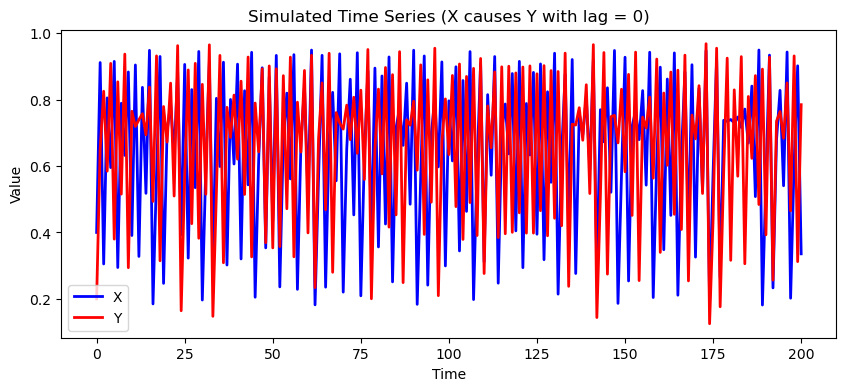

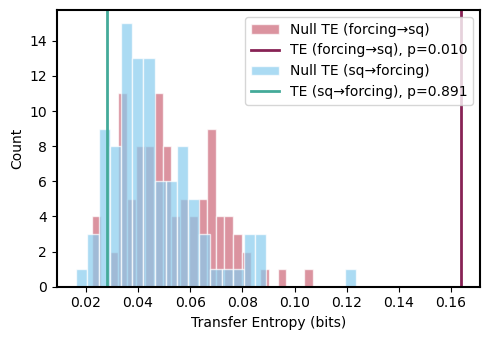

True

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}



r_x = 3.8        
r_y = 3.5       
B_yx = 0.1      
LAG = 0          
t_total = 200    

X = np.zeros(t_total + 1)
Y = np.zeros(t_total + 1)
X[0] = 0.4
Y[0] = 0.2

for t in range(t_total):
    X[t+1] = r_x * X[t] * (1 - X[t])
    if (t + 1) < LAG:
        Y[t+1] = r_y * Y[t] * (1 - Y[t])
    else:
        Y[t+1] = r_y * Y[t] * (1 - Y[t]) + B_yx * X[t - LAG + 1]

time = np.arange(t_total + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, X, 'b-', linewidth=2, label='X')
plt.plot(time, Y, 'r-', linewidth=2, label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Simulated Time Series (X causes Y with lag = {LAG})')
plt.legend()
plt.show()


# save X and Y to csv and add a time column
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})
# df.to_csv('X_Y.csv', index=False)




# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df['X'].values      # source (precession)
y = df['Y'].values    # target (residual)

from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

# # flip x and y upside down
x = x[::-1]
y = y[::-1]


result =sa.transfer_entropy_surrogate_test(x,y,forcing_bins=4,sq_bins=4)
result

# Testing TE, linear system

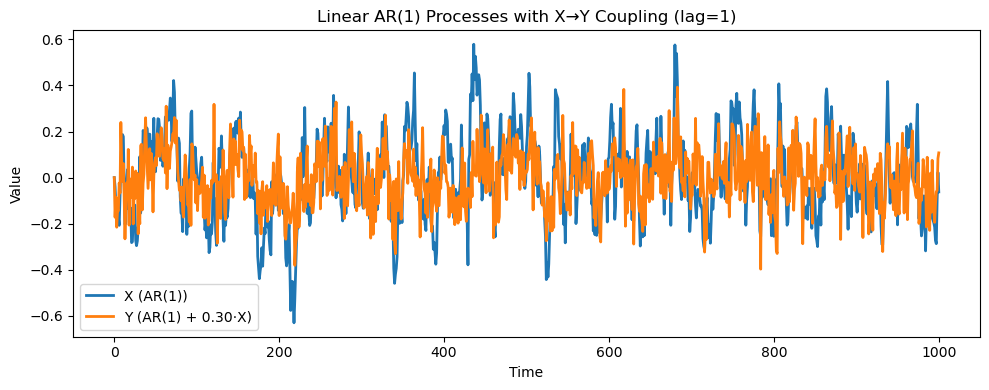

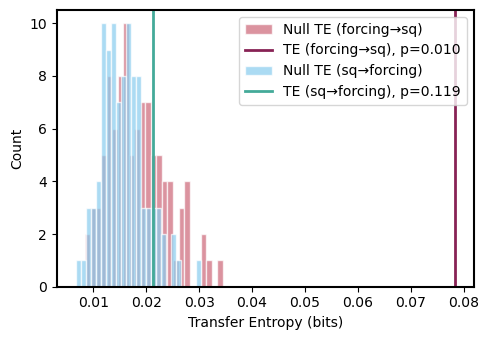

Unidirectional X→Y significant? → True


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy
from toolbox import sq_ana as sa
import importlib

# re-load in case you’re iterating
importlib.reload(sa)

# ------------------
# PARAMETERS
# ------------------
t_total = 1000
a_x = 0.8       # AR coefficient for X
a_y = 0.2       # AR coefficient for Y
B_yx = 0.3      # coupling strength X→Y
sigma_x = 0.1   # noise std for X
sigma_y = 0.1   # noise std for Y
LAG = 1         # one‐step lag

# ------------------
# ALLOCATE
# ------------------
X = np.zeros(t_total + 1)
Y = np.zeros(t_total + 1)
X[0] = 0.0
Y[0] = 0.0

# ------------------
# SIMULATE
# ------------------
for t in range(t_total):
    # AR(1) for X with noise
    X[t+1] = a_x * X[t] + np.random.normal(scale=sigma_x)
    # Y depends on its own history + linear coupling from X[t]
    if t+1 < LAG:
        Y[t+1] = a_y * Y[t] + np.random.normal(scale=sigma_y)
    else:
        Y[t+1] = (
            a_y * Y[t]
            + B_yx * X[t - LAG + 1]
            + np.random.normal(scale=sigma_y)
        )

# ------------------
# PLOT
# ------------------
time = np.arange(t_total + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, X, label='X (AR(1))', linewidth=2)
plt.plot(time, Y, label=f'Y (AR(1) + {B_yx:.2f}·X)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Linear AR(1) Processes with X→Y Coupling (lag={LAG})')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------
# SAVE TO CSV
# ------------------
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})
# df.to_csv('X_Y_linear.csv', index=False)

# ------------------
# RUN SURROGATE TEST
# ------------------
# flip for your test function
x = X[::-1]
y = Y[::-1]

result = sa.transfer_entropy_surrogate_test(
    forcing=x,
    sq=y,
    forcing_bins=4,
    sq_bins=4,
    k=1,
    n_surr=100,
    p=0.05,
    if_plot=True,
    dpi=100
)
print("Unidirectional X→Y significant? →", result)


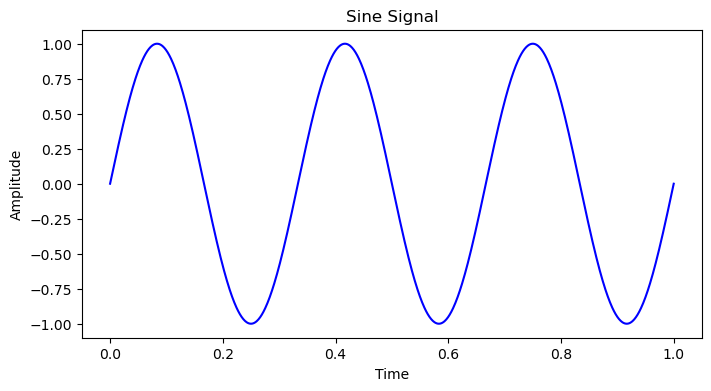

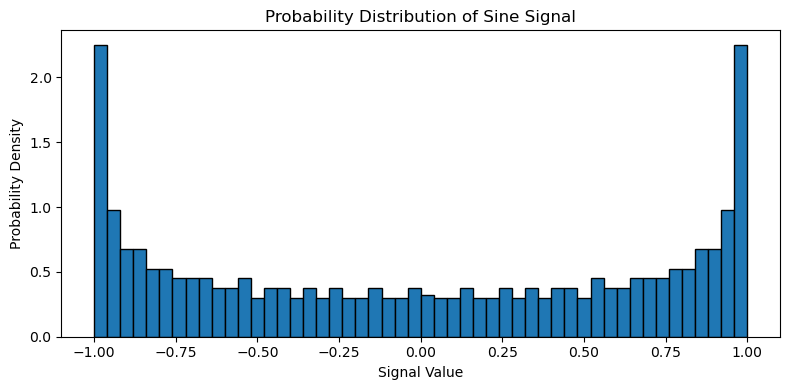

Sine Signal Entropy: 5.3726 bits


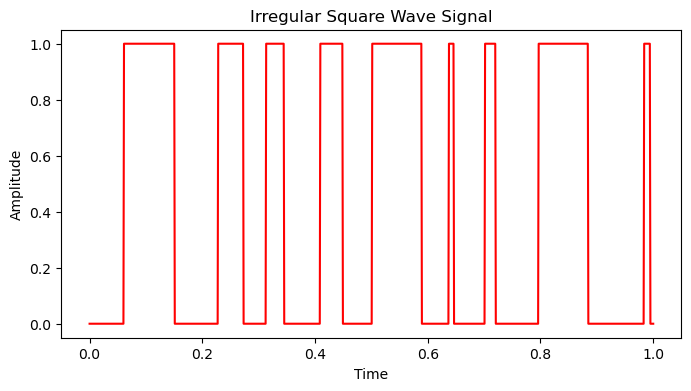

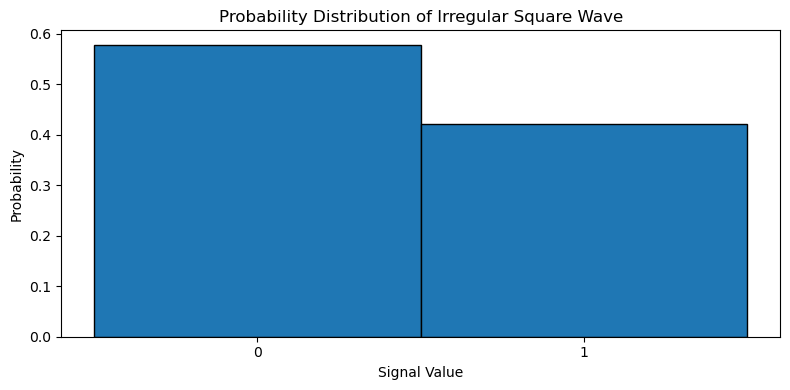

Irregular Square Wave Entropy: 0.9824 bits


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to compute entropy (in bits) from a signal
def compute_entropy(signal, bins=50):
    hist, edges = np.histogram(signal, bins=bins, density=False)
    p = hist / np.sum(hist)  # probability for each bin
    p = p[p > 0]              # remove zero entries
    return -np.sum(p * np.log2(p))

# 1. Generate a sine signal of length 1000
n = 1000
t = np.linspace(0, 1, n)
sine_signal = np.sin(6 * np.pi * t)  # one full cycle

# Plot the sine signal
plt.figure(figsize=(8, 4))
plt.plot(t, sine_signal, label='Sine Signal', color='blue')
plt.title('Sine Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')


# 2. Plot its probability distribution
plt.figure(figsize=(8, 4))
plt.hist(sine_signal, bins=50, density=True, edgecolor='black')
plt.title('Probability Distribution of Sine Signal')
plt.xlabel('Signal Value')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

# 3. Calculate the information entropy
entropy_sine = compute_entropy(sine_signal, bins=50)
print(f"Sine Signal Entropy: {entropy_sine:.4f} bits")

# 4. Irregular square wave signal
#    Random durations between 1 and 100 samples for high/low phases
signal_sq = []
state = 0  # start at low (0)
while len(signal_sq) < n:
    dur = np.random.randint(1, 101)
    signal_sq.extend([state] * dur)
    state = 1 - state  # toggle state
signal_sq = np.array(signal_sq[:n])

# Plot the irregular square wave signal
plt.figure(figsize=(8, 4))
plt.plot(t, signal_sq, label='Irregular Square Wave', color='red')
plt.title('Irregular Square Wave Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot its probability distribution
plt.figure(figsize=(8, 4))
plt.hist(signal_sq, bins=[-0.5, 0.5, 1.5], density=True, edgecolor='black')
plt.xticks([0, 1])
plt.title('Probability Distribution of Irregular Square Wave')
plt.xlabel('Signal Value')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

# Calculate the information entropy
entropy_sq = compute_entropy(signal_sq, bins=2)
print(f"Irregular Square Wave Entropy: {entropy_sq:.4f} bits")


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_joint_prob_colormap(x, y, xbins, ybins):
    # 1) Joint counts
    counts, x_edges, y_edges = np.histogram2d(x, y, bins=[xbins, ybins])

    # 2) Convert to probabilities
    P = counts / counts.sum()  # shape (Bx, By)
    
    # 3) Plot
    fig, ax = plt.subplots()
    # use pcolormesh so axes correspond to the real bin‐edges
    X, Y = np.meshgrid(x_edges, y_edges)
    pcm = ax.pcolormesh(X, Y, P.T, shading='auto')
    fig.colorbar(pcm, ax=ax, label='P(X,Y)')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Joint Probability Distribution')
    plt.show()

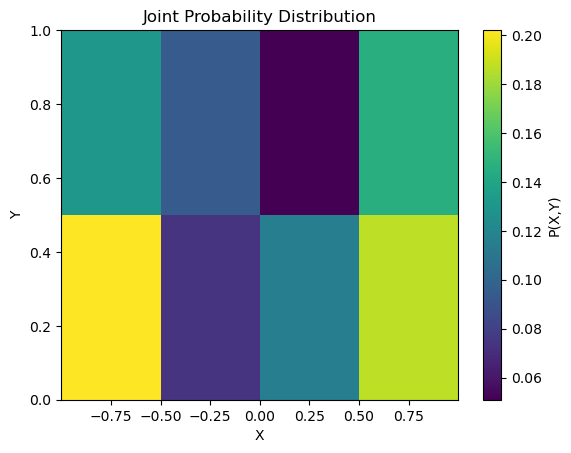

In [15]:
# assuming you've already done:
x = sine_signal
y = signal_sq
xbins = np.histogram_bin_edges(x, bins=4)
ybins = np.histogram_bin_edges(y, bins=2)

plot_joint_prob_colormap(x, y, xbins, ybins)

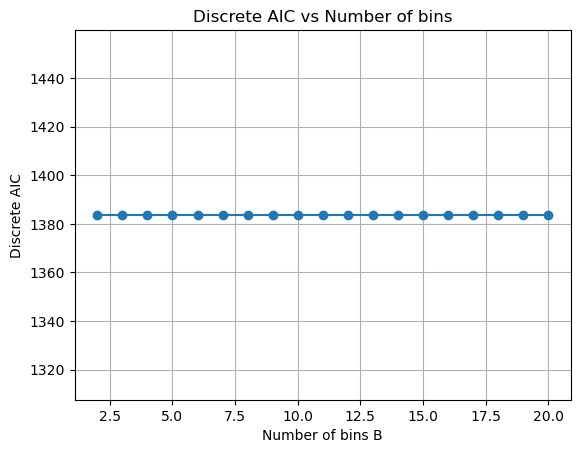

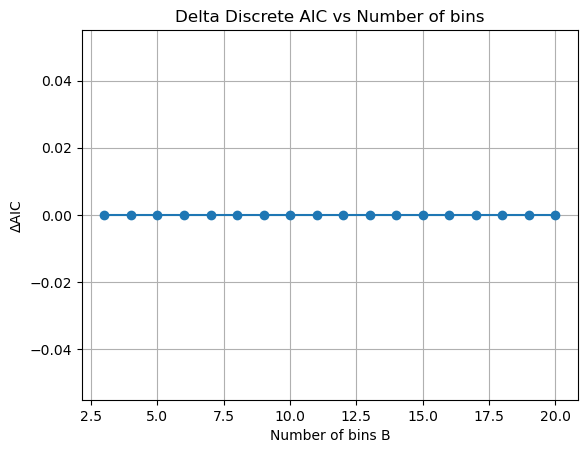

In [11]:
plot_aic_delta_discrete(signal_sq)

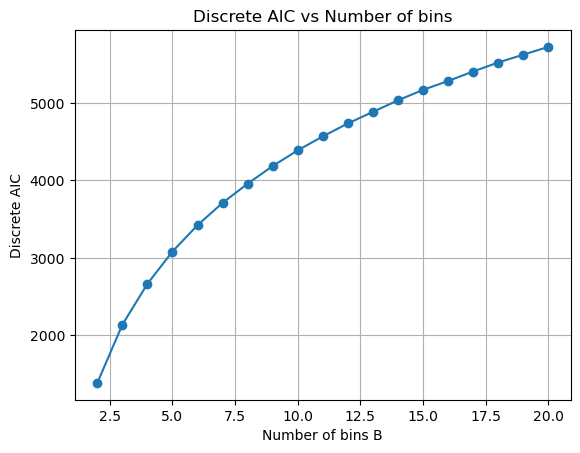

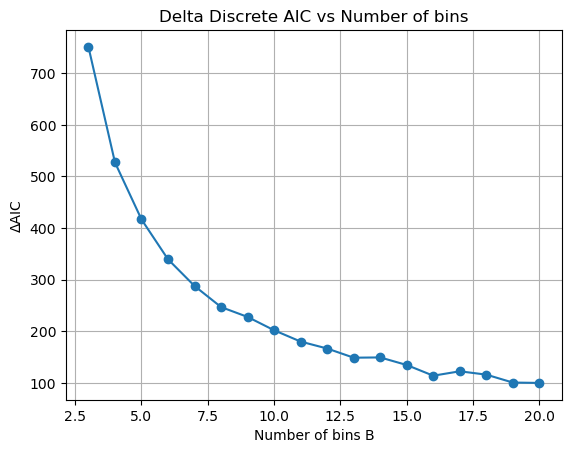

In [10]:
plot_aic_delta_discrete(sine_signal)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_aic_delta(series):
    """
    Compute AIC for histogram bin counts B from 2 to 20,
    then plot the AIC and delta-AIC as separate figures.
    """
    series = np.asarray(series)
    x_min, x_max = series.min(), series.max()
    N = series.size

    b_values = np.arange(2, 21)
    aic_list = []

    for B in b_values:
        # Build histogram
        counts, _ = np.histogram(series, bins=B, range=(x_min, x_max))
        bin_width = (x_max - x_min) / B

        # Compute log-likelihood for nonzero bins
        positive = counts > 0
        ll = np.sum(counts[positive] * np.log(counts[positive] / (N * bin_width)))

        # Number of nonempty bins
        K_nonzero = np.count_nonzero(counts)

        # AIC: -2 * log-likelihood + 2 * (number of parameters)
        aic = -2 * ll + 2 * (K_nonzero - 1)
        aic_list.append(aic)

    aic_list = np.array(aic_list)
    delta_aic = np.diff(aic_list)

    # Plot AIC vs B
    plt.figure()
    plt.plot(b_values, aic_list)
    plt.xlabel('Number of bins B')
    plt.ylabel('AIC')
    plt.title('AIC vs Number of bins')
    plt.show()

    # Plot ΔAIC vs B
    plt.figure()
    plt.plot(b_values[1:], delta_aic)
    plt.xlabel('Number of bins B')
    plt.ylabel('ΔAIC')
    plt.title('Delta AIC vs Number of bins')
    plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_aic_delta_discrete(series):
    """
    Compute discrete-multinomial AIC for histogram bin counts B from 2 to 20,
    then plot the AIC and delta-AIC as separate figures.
    
    Uses the log-likelihood of a multinomial (ignoring bin width).
    """
    series = np.asarray(series)
    x_min, x_max = series.min(), series.max()
    N = series.size

    b_values = np.arange(2, 21)
    aic_list = []

    for B in b_values:
        # Build histogram
        counts, bin_edges = np.histogram(series, bins=B, range=(x_min, x_max))
        
        # Number of non-empty bins
        k_nonzero = counts > 0
        K = np.count_nonzero(k_nonzero)
        
        # Discrete log-likelihood: sum n_k * log(n_k / N)
        ll = np.sum(counts[k_nonzero] * np.log(counts[k_nonzero] / N))
        
        # AIC: -2 * ll + 2*(#free parameters) where free params = K - 1
        aic = -2 * ll + 2 * (K - 1)
        aic_list.append(aic)

    aic_list = np.array(aic_list)
    delta_aic = np.diff(aic_list)

    # Plot AIC vs B
    plt.figure()
    plt.plot(b_values, aic_list, marker='o')
    plt.xlabel('Number of bins B')
    plt.ylabel('Discrete AIC')
    plt.title('Discrete AIC vs Number of bins')
    plt.grid(True)
    plt.show()

    # Plot ΔAIC vs B
    plt.figure()
    plt.plot(b_values[1:], delta_aic, marker='o')
    plt.xlabel('Number of bins B')
    plt.ylabel('ΔAIC')
    plt.title('Delta Discrete AIC vs Number of bins')
    plt.grid(True)
    plt.show()



In [7]:
import numpy as np
import matplotlib.pyplot as plt

def transfer_entropy_with_significance(x, y, nbins_x=8, nbins_y=2, k=1, n_surr=100, random_state=None):
    """
    Compute transfer entropy TE_{X->Y} and assess its significance, 
    then plot the null distribution of surrogate TE values with the empirical TE marked.

    Returns:
        te_emp: empirical TE (bits)
        p_value: fraction of surrogate TE >= te_emp
        te_surr: array of surrogate TE values
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    if len(y) != n:
        raise ValueError("Source and target must have same length")
    
    # Discretize x
    if not np.issubdtype(x.dtype, np.integer):
        xbins = np.histogram_bin_edges(x, bins=nbins_x)
        x_disc = np.digitize(x, xbins) - 1
        x_disc = np.clip(x_disc, 0, nbins_x-1)
        Nx = nbins_x
    else:
        x_disc = x
        Nx = int(x.max() - x.min() + 1)
    # Discretize y
    if not np.issubdtype(y.dtype, np.integer):
        ybins = np.histogram_bin_edges(y, bins=nbins_y)
        y_disc = np.digitize(y, ybins) - 1
        y_disc = np.clip(y_disc, 0, nbins_y-1)
        Ny = nbins_y
    else:
        y_disc = y
        Ny = int(y.max() - y.min() + 1)

    # TE computation helper
    def compute_te(xd, yd):
        counts = np.zeros((Ny, Ny, Nx), dtype=int)
        for i in range(n - k):
            counts[yd[i+k], yd[i], xd[i]] += 1
        total = counts.sum()
        N_yx = counts.sum(axis=0)
        counts_yy = counts.sum(axis=2)
        N_ycur = counts_yy.sum(axis=0)
        te_val = 0.0
        for y_next in range(Ny):
            for y_cur in range(Ny):
                for x_cur in range(Nx):
                    c = counts[y_next, y_cur, x_cur]
                    if c > 0:
                        p_xyz = c / total
                        p_y1_yx = c / N_yx[y_cur, x_cur]
                        p_y1_y = counts_yy[y_next, y_cur] / N_ycur[y_cur]
                        te_val += p_xyz * np.log2(p_y1_yx / p_y1_y)
        return te_val

    # Empirical TE
    te_emp = compute_te(x_disc, y_disc)

    # Surrogate tests
    rng = np.random.RandomState(random_state)
    te_surr = np.zeros(n_surr)
    for i in range(n_surr):
        xs = rng.permutation(x_disc)
        te_surr[i] = compute_te(xs, y_disc)

    # p-value
    p_value = np.mean(te_surr >= te_emp)

    # Plot null distribution
    plt.figure(figsize=(8, 4))
    plt.hist(te_surr, bins=25, alpha=0.7)
    plt.axvline(te_emp, linestyle='--', linewidth=2, label='Empirical TE')
    plt.xlabel('Transfer Entropy (bits)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Surrogate Null Distribution of TE')
    plt.tight_layout()
    plt.show()

    return te_emp, p_value, te_surr




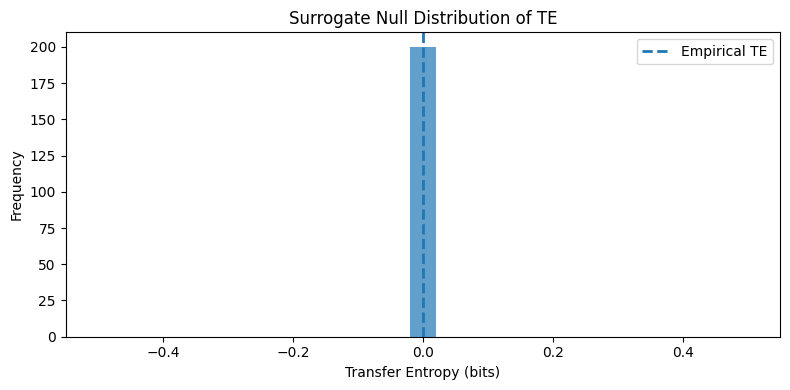

Empirical TE = 0.0000 bits, p-value = 1.000


In [8]:

n = 1000
t = np.linspace(0, 1, n)
sine_signal = np.sin(6 * np.pi * t)
# Irregular square wave
signal_sq = []
state = 0
while len(signal_sq) < n:
    dur = np.random.randint(1, 101)
    signal_sq.extend([state] * dur)
signal_sq = np.array(signal_sq[:n])

te_val, p_val, surr = transfer_entropy_with_significance(
    sine_signal, signal_sq, nbins_x=8, nbins_y=2, k=1, n_surr=200, random_state=42
)
print(f"Empirical TE = {te_val:.4f} bits, p-value = {p_val:.3f}")

In [4]:
import numpy as np

# 1. Regenerate the synthetic data
n = 1000
t = np.linspace(0, 1, n)
sine_signal = np.sin(6 * np.pi * t)

# Irregular square wave (0/1)
signal_sq = []
state = 0
while len(signal_sq) < n:
    dur = np.random.randint(1, 101)
    signal_sq.extend([state] * dur)
signal_sq = np.array(signal_sq[:n])

# 2. Discretize the source (sine) into 8 equiprobable bins
nbins_x = 8
xbins = np.histogram_bin_edges(sine_signal, bins=nbins_x)
x_disc = np.digitize(sine_signal, xbins) - 1  # initial bin indices may go 0..8
# Clip any index equal to nbins_x back to nbins_x-1
x_disc = np.where(x_disc == nbins_x, nbins_x - 1, x_disc)

# Discretize the target (square) into its natural 2 states
y_disc = signal_sq  # already 0 or 1

# 3. Compute joint counts: count[y_next, y_cur, x_cur]
Ny = 2   # target alphabet size
Nx = nbins_x
counts = np.zeros((Ny, Ny, Nx), dtype=int)
for i in range(n - 1):
    x_cur = x_disc[i]
    y_cur = y_disc[i]
    y_next = y_disc[i + 1]
    counts[y_next, y_cur, x_cur] += 1

# 4. Marginal counts
# N(y_cur, x_cur) = sum over y_next
N_yx = counts.sum(axis=0)          # shape (y_cur, x_cur)
# N(y_next, y_cur) = sum over x_cur
counts_yy = counts.sum(axis=2)     # shape (y_next, y_cur)
# N(y_cur) = sum over y_next of counts_yy
N_ycur = counts_yy.sum(axis=0)     # shape (y_cur,)

# 5. Total transitions (n - 1)
total = counts.sum()

# 6. Compute transfer entropy TE_{X→Y}
TE_xy = 0.0
for y_next in range(Ny):
    for y_cur in range(Ny):
        for x_cur in range(Nx):
            c_xyz = counts[y_next, y_cur, x_cur]
            if c_xyz > 0:
                # joint probability p(y_next, y_cur, x_cur)
                p_xyz = c_xyz / total
                # conditional probabilities
                p_y1_given_yx = c_xyz / N_yx[y_cur, x_cur]
                p_y1_given_y  = counts_yy[y_next, y_cur] / N_ycur[y_cur]
                # accumulate TE
                TE_xy += p_xyz * np.log2(p_y1_given_yx / p_y1_given_y)

print(f"Transfer Entropy (sine → square) = {TE_xy:.6f} bits")


Transfer Entropy (sine → square) = 0.000000 bits


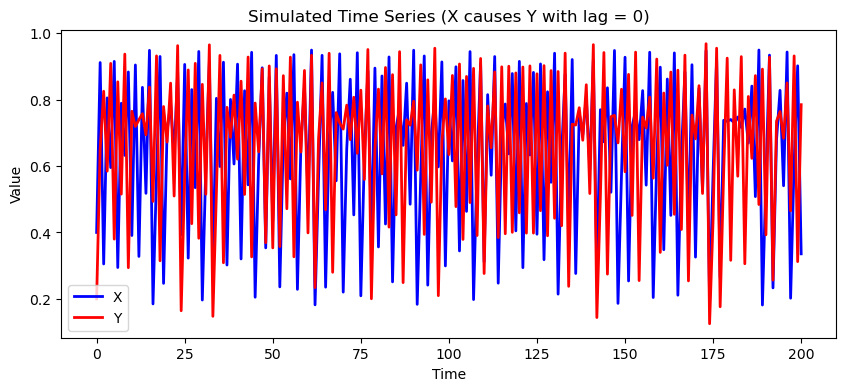

TE(pre→residual) = 0.5104 bits


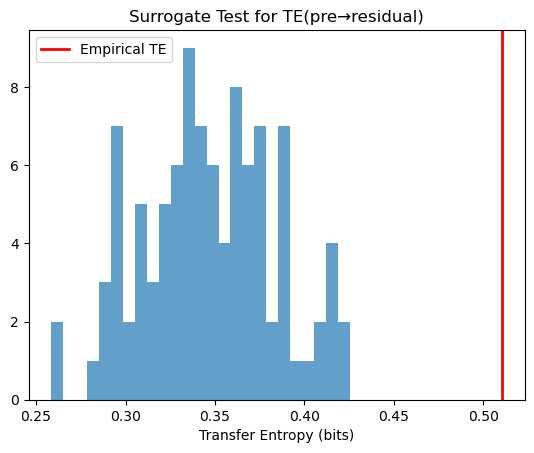

p-value = 0.000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}



r_x = 3.8        
r_y = 3.5       
B_yx = 0.1      
LAG = 0          
t_total = 200    

X = np.zeros(t_total + 1)
Y = np.zeros(t_total + 1)
X[0] = 0.4
Y[0] = 0.2

for t in range(t_total):
    X[t+1] = r_x * X[t] * (1 - X[t])
    if (t + 1) < LAG:
        Y[t+1] = r_y * Y[t] * (1 - Y[t])
    else:
        Y[t+1] = r_y * Y[t] * (1 - Y[t]) + B_yx * X[t - LAG + 1]

time = np.arange(t_total + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, X, 'b-', linewidth=2, label='X')
plt.plot(time, Y, 'r-', linewidth=2, label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Simulated Time Series (X causes Y with lag = {LAG})')
plt.legend()
plt.show()


# save X and Y to csv and add a time column
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})
# df.to_csv('X_Y.csv', index=False)






# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df['X'].values      # source (precession)
y = df['Y'].values    # target (residual)

# y = df['X'].values      # source (precession)
# x = df['Y'].values    # target (residual)

# # flip x and y upside down
# x = x[::-1]
# y = y[::-1]

# 1) Discretize into nbins equiprobable bins
nbins = 8
xbins = np.histogram_bin_edges(x, bins=nbins)
ybins = np.histogram_bin_edges(y, bins=nbins)
x_disc = np.digitize(x, xbins) - 1
y_disc = np.digitize(y, ybins) - 1

# 2) Compute TE from pre→residual with history length k=1
#    note: drop last/first sample to align t→t+1
te_xy = transfer_entropy(x_disc[:-1], y_disc[1:], k=1)
print(f"TE(pre→residual) = {te_xy:.4f} bits")

# 3) Permutation‐based surrogate test
n_surr = 100
te_null = np.zeros(n_surr)
for i in range(n_surr):
    xs = np.random.permutation(x_disc)
    te_null[i] = transfer_entropy(xs[:-1], y_disc[1:], k=1)

# 4) Plot null distribution
plt.hist(te_null, bins=25, alpha=0.7)
plt.axvline(te_xy, color='r', lw=2, label='Empirical TE')
plt.xlabel('Transfer Entropy (bits)')
plt.legend()
plt.title('Surrogate Test for TE(pre→residual)')
plt.show()

# 5) Compute p-value
p_value = np.mean(te_null >= te_xy)
print(f"p-value = {p_value:.3f}")